In [1]:
import numpy as np
import pandas as pd
import time
from datetime import datetime
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearnex import patch_sklearn
patch_sklearn()
from hpsklearn import *
from hyperopt import hp, tpe

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
C:\Users\marce\Anaconda2\envs\doutorado\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [2]:
SEED = 10

In [3]:
print(f"Execution started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Execution started at 2022-02-21 17:00:21.


In [4]:
filepath = "../Data Preprocessing/iot23_combined_100k.csv"
df = pd.read_csv(filepath)

In [5]:
df

,Unnamed: 0,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,...,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
0,0,2.998796,0,0,0.0,3.0,180.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
1,1,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
2,2,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
3,3,2.998804,0,0,0.0,3.0,180.0,0.0,0.0,Benign,...,0,0,0,1,0,0,0,0,0,0
4,4,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,Benign,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444669,99994,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
1444670,99995,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
1444671,99996,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
1444672,99997,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0


In [6]:
del df['Unnamed: 0']

In [7]:
df['label'].value_counts()

PartOfAHorizontalPortScan     825939
Okiru                         262690
Benign                        197809
DDoS                          138777
C&C                            15100
Attack                          3915
C&C-HeartBeat                    349
C&C-FileDownload                  43
C&C-Torii                         30
FileDownload                      13
C&C-HeartBeat-FileDownload         8
C&C-Mirai                          1
Name: label, dtype: int64

In [8]:
good = 'Benign'
bad = 'PartOfAHorizontalPortScan'
filtered_labels = df['label'].value_counts().index.drop([good,bad])
for label in filtered_labels:
    df.drop(df[df.label == label].index, inplace=True) 
print(filtered_labels)
df['label'].value_counts()

Index(['Okiru', 'DDoS', 'C&C', 'Attack', 'C&C-HeartBeat', 'C&C-FileDownload',
       'C&C-Torii', 'FileDownload', 'C&C-HeartBeat-FileDownload', 'C&C-Mirai'],
      dtype='object')


PartOfAHorizontalPortScan    825939
Benign                       197809
Name: label, dtype: int64

In [9]:
df.loc[(df.label == good), 'label'] = 0
df.loc[(df.label == bad), 'label'] = 1
df = df.astype({'label': int})
df['label'].value_counts()

1    825939
0    197809
Name: label, dtype: int64

In [10]:
#for label in df['label'].value_counts().index:
#    if rank < 3:
#        df.loc[(df.label == label), 'label'] = rank
#    else:
#        df.drop(df[df.label == label].index, inplace=True) 
#    rank += 1
#df = df.astype({'label': int})

In [11]:
X = df[['duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'proto_icmp', 'proto_tcp', 'proto_udp', 'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTO', 'conn_state_RSTOS0', 'conn_state_RSTR', 'conn_state_RSTRH', 'conn_state_S0', 'conn_state_S1', 'conn_state_S2', 'conn_state_S3', 'conn_state_SF', 'conn_state_SH', 'conn_state_SHR']].values

In [12]:
Y = df['label'].values

In [13]:
df

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_icmp,...,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
0,2.998796,0,0,0.0,3.0,180.0,0.0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,2.998804,0,0,0.0,3.0,180.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444669,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
1444670,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
1444671,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
1444672,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=SEED, test_size=0.2)

In [15]:
best_results = {}

success = 0

classifiers = [
    ada_boost('ab'),
    decision_tree('dt'),
    extra_trees('et'),
    gaussian_nb('gnb'),
    gradient_boosting('gb'),
    knn('knn'),
    liblinear_svc('svc-ll'),
    linear_discriminant_analysis('lda'),
    multinomial_nb('mnb'),
    one_vs_one('ovo'),
    one_vs_rest('ovr'),
    output_code('oc'),
    passive_aggressive('pa'),
    quadratic_discriminant_analysis('qda'),
    random_forest('rf'),
    sgd('sgd'),
    svc('svc'),
    svc_linear('svc-l'),
    svc_poly('svc-p'),
    svc_rbf('svc-r'),
    svc_sigmoid('svc-s'),
    xgboost_classification('xgb')
]

for clf in classifiers:

    print(f'\n******************** {clf.name} ********************')
    
    try:

        estim = HyperoptEstimator(classifier=clf,
                                  preprocessing=[normalizer('my_pre')],
                                  algo=tpe.suggest,
                                  max_evals=10,
                                  trial_timeout=300,
                                  seed=SEED,
                                  n_jobs=-1)

        estim.fit(X_train, Y_train, random_state=SEED)

        score = estim.score(X_test, Y_test)
        print(score)

        best_model = estim.best_model()
        print(best_model)

        best_results[clf.name] = score
        success += 1
        
    except Exception as e:
        print(f'********** Could not fit {clf.name}: {str(e)}. **********')
        pass

print(f'****************************************')
print(f'**** Fit success rate: {success}/{len(classifiers)} ****')
print(f'****************************************')


******************** sklearn_AdaBoostClassifier ********************
100%|████████████████████████████████████████████████| 10/10 [00:54<00:00, 54.10s/trial, best loss: 0.0868742368742369]
0.912009768009768
{'learner': AdaBoostClassifier(algorithm='SAMME', learning_rate=0.004675896422062141,
                   n_estimators=36, random_state=0), 'preprocs': (Normalizer(norm='l1'),), 'ex_preprocs': ()}

******************** sklearn_DecisionTreeClassifier ********************
100%|███████████████████████████████████████████████| 10/10 [00:01<00:00,  1.77s/trial, best loss: 0.08429181929181928]
0.9141929181929181
{'learner': DecisionTreeClassifier(criterion='entropy', max_features='log2',
                       min_samples_leaf=4, min_samples_split=8, random_state=3), 'preprocs': (Normalizer(),), 'ex_preprocs': ()}

******************** sklearn_ExtraTreesClassifier ********************
100%|████████████████████████████████████████████████| 10/10 [00:24<00:00, 24.03s/trial, best loss: 0.084

100%|███████████████████████████████████████████████| 10/10 [00:22<00:00, 22.86s/trial, best loss: 0.08439560439560445]
0.9140952380952381
{'learner': KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=6), 'preprocs': (Normalizer(norm='l1'),), 'ex_preprocs': ()}

******************** sklearn_LinearSVC ********************
100%|███████████████████████████████████████████████| 10/10 [00:01<00:00,  1.88s/trial, best loss: 0.13426739926739928]
0.8618412698412699
{'learner': LinearSVC(C=23168.491761012232, class_weight='balanced',
          intercept_scaling=0.6311718989758247, loss='hinge', random_state=0,
          tol=0.00988670757716758, verbose=False), 'preprocs': (Normalizer(),), 'ex_preprocs': ()}

******************** sklearn_LinearDiscriminantAnalysis ********************
  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

C:\Users\marce\Anaconda2\envs\doutorado\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
ERROR:hyperopt.fmin:job exception: n_components cannot be larger than min(n_features, n_classes - 1).


  0%|                                                                            | 0/1 [00:01<?, ?trial/s, best loss=?]
********** Could not fit sklearn_LinearDiscriminantAnalysis: n_components cannot be larger than min(n_features, n_classes - 1).. **********

******************** sklearn_MultinomialNB ********************
  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: Negative values in data passed to MultinomialNB (input X)


  0%|                                                                            | 0/1 [00:01<?, ?trial/s, best loss=?]
********** Could not fit sklearn_MultinomialNB: Negative values in data passed to MultinomialNB (input X). **********

******************** sklearn_OneVsOneClassifier ********************
 80%|████████████████████████████████████████████████████████████▊               | 4/5 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: Unable to cast Python instance to C++ type (compile in debug mode for details)


 80%|████████████████████████████████████████████████████████████▊               | 4/5 [00:03<?, ?trial/s, best loss=?]
********** Could not fit sklearn_OneVsOneClassifier: Unable to cast Python instance to C++ type (compile in debug mode for details). **********

******************** sklearn_OneVsRestClassifier ********************
 80%|████████████████████████████████████████████████████████████▊               | 4/5 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: Unable to cast Python instance to C++ type (compile in debug mode for details)


 80%|████████████████████████████████████████████████████████████▊               | 4/5 [00:05<?, ?trial/s, best loss=?]
********** Could not fit sklearn_OneVsRestClassifier: Unable to cast Python instance to C++ type (compile in debug mode for details). **********

******************** sklearn_OutputCodeClassifier ********************
 80%|████████████████████████████████████████████████████████████▊               | 4/5 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: Unable to cast Python instance to C++ type (compile in debug mode for details)


 80%|████████████████████████████████████████████████████████████▊               | 4/5 [00:06<?, ?trial/s, best loss=?]
********** Could not fit sklearn_OutputCodeClassifier: Unable to cast Python instance to C++ type (compile in debug mode for details). **********

******************** sklearn_PassiveAggressiveClassifier ********************
100%|███████████████████████████████████████████████| 10/10 [00:06<00:00,  6.95s/trial, best loss: 0.13440170940170937]
0.8628766788766788
{'learner': PassiveAggressiveClassifier(C=0.0032676916715920906, fit_intercept=False,
                            loss='squared_hinge', max_iter=125525750.0,
                            n_jobs=-1, random_state=2,
                            tol=1.3981423482756573e-05, verbose=False), 'preprocs': (Normalizer(),), 'ex_preprocs': ()}

******************** sklearn_QuadraticDiscriminantAnalysis ********************
100%|███████████████████████████████████████████████| 10/10 [00:01<00:00,  1.98s/trial, best loss: 0.1

C:\Users\marce\Anaconda2\envs\doutorado\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.8162393162393162
{'learner': QuadraticDiscriminantAnalysis(reg_param=0.09242664244599941), 'preprocs': (Normalizer(),), 'ex_preprocs': ()}

******************** sklearn_RandomForestClassifier ********************
100%|████████████████████████████████████████████████| 10/10 [00:04<00:00,  4.17s/trial, best loss: 0.0842857142857143]
0.9141880341880342
{'learner': RandomForestClassifier(criterion='entropy', max_features='log2',
                       min_samples_leaf=2, n_estimators=201, n_jobs=-1,
                       random_state=0, verbose=False), 'preprocs': (Normalizer(),), 'ex_preprocs': ()}

******************** sklearn_SGDClassifier ********************
100%|███████████████████████████████████████████████| 10/10 [00:07<00:00,  7.70s/trial, best loss: 0.08620879120879121]
0.9082002442002443
{'learner': SGDClassifier(alpha=2.2770994808702035e-06, eta0=8.6129264380661e-05,
              l1_ratio=0.34593316065756197, loss='modified_huber',
              max_iter=20843123.0, n_jobs

ERROR:hyperopt.fmin:job exception: Unable to cast Python instance to C++ type (compile in debug mode for details)


 83%|███████████████████████████████████████████████████████████████▎            | 5/6 [00:01<?, ?trial/s, best loss=?]
********** Could not fit switch: Unable to cast Python instance to C++ type (compile in debug mode for details). **********

******************** sklearn_SVC ********************
100%|██████████████████████████████████████████████| 10/10 [02:14<00:00, 134.76s/trial, best loss: 0.11509157509157508]
0.8847814407814408
{'learner': SVC(C=0.0003933814949877904, cache_size=512, degree=1, gamma='auto',
    kernel='linear', max_iter=88374327.0, random_state=1,
    tol=0.0038576452705817977), 'preprocs': (Normalizer(),), 'ex_preprocs': ()}

******************** sklearn_SVC ********************
  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: Unable to cast Python instance to C++ type (compile in debug mode for details)


  0%|                                                                            | 0/1 [00:01<?, ?trial/s, best loss=?]
********** Could not fit sklearn_SVC: Unable to cast Python instance to C++ type (compile in debug mode for details). **********

******************** sklearn_SVC ********************
100%|███████████████████████████████████████████████| 10/10 [01:44<00:00, 104.70s/trial, best loss: 0.1206593406593407]
0.8348571428571429
{'learner': SVC(C=0.008208933983379988, cache_size=512, degree=1, gamma=0.22104254072803164,
    max_iter=384162737.0, random_state=1, tol=9.003290909653738e-05), 'preprocs': (Normalizer(norm='l1'),), 'ex_preprocs': ()}

******************** sklearn_SVC ********************
100%|██████████████████████████████████████████████| 10/10 [03:10<00:00, 190.48s/trial, best loss: 0.08619047619047615]
0.9121758241758242
{'learner': SVC(C=0.07076849410776978, cache_size=512, coef0=0.002898108893432939, degree=1,
    gamma=0.005573740868795477, kernel='sigmoid', 

C:\Users\marce\Anaconda2\envs\doutorado\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:01:13] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9141538461538462
{'learner': XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.672966580328781, colsample_bynode=1,
              colsample_bytree=0.841937648565246, enable_categorical=False,
              gamma=2.513475906959667, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.019817423802151644,
              max_delta_step=0, max_depth=2, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=2800, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0.024380667920122622, reg_lambda=1.2033109853317083,
              scale_pos_weight=1, seed=1

In [16]:
for clf in classifiers:
    if clf.name not in best_results.keys():
        best_results[clf.name] = 0.0
best_results = dict(sorted(best_results.items()))
print(best_results)

{'sklearn_AdaBoostClassifier': 0.912009768009768, 'sklearn_DecisionTreeClassifier': 0.9141929181929181, 'sklearn_ExtraTreesClassifier': 0.8987741147741147, 'sklearn_GaussianNB': 0.8626373626373627, 'sklearn_GradientBoostingClassifier': 0.9141098901098901, 'sklearn_KNeighborsClassifier': 0.9140952380952381, 'sklearn_LinearDiscriminantAnalysis': 0.0, 'sklearn_LinearSVC': 0.8618412698412699, 'sklearn_MultinomialNB': 0.0, 'sklearn_OneVsOneClassifier': 0.0, 'sklearn_OneVsRestClassifier': 0.0, 'sklearn_OutputCodeClassifier': 0.0, 'sklearn_PassiveAggressiveClassifier': 0.8628766788766788, 'sklearn_QuadraticDiscriminantAnalysis': 0.8162393162393162, 'sklearn_RandomForestClassifier': 0.9141880341880342, 'sklearn_SGDClassifier': 0.9082002442002443, 'sklearn_SVC': 0.9121758241758242, 'sklearn_XGBClassifier': 0.9141538461538462, 'switch': 0.0}


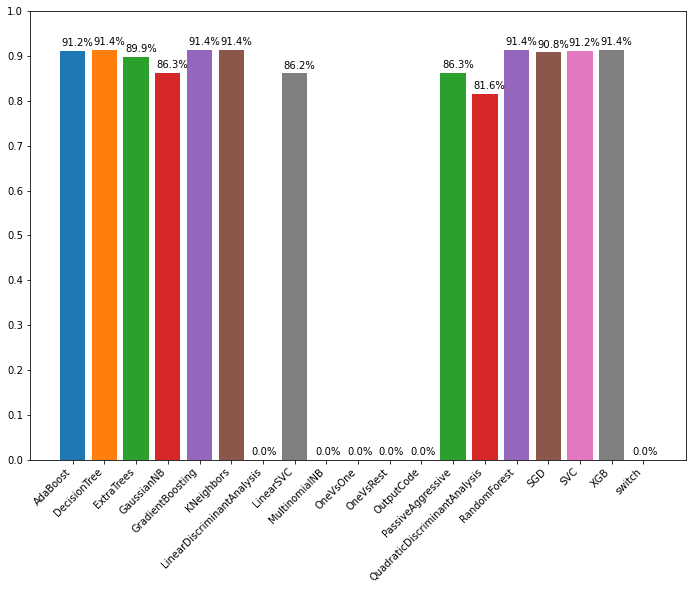

In [17]:
import matplotlib.pyplot as plt

names = [x.replace('sklearn_','').replace('Classifier','') for x in best_results.keys()]
values = list(best_results.values())

plt.figure(figsize=(11.75,8.25))
idx = 0
for key, value in best_results.items():
    plt.bar(key,value)
    plt.text(idx-0.35,value+0.01,f'{100*value:.1f}%')
    idx += 1
plt.xticks(rotation=45, ha='right')
plt.xticks(range(0,len(best_results)),names)
plt.yticks(np.linspace(0,1,11))
plt.ylim(0,1)
plt.show()

In [18]:
print(f"Execution finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Execution finished at 2022-02-21 21:03:37.
